# Learning Distance


## Neural Network or Multilayer Perceptron
A Multilayer Perceptron consists of an input layer, multiple hiddenlayers and an output layer. The MLP is a feedforward algorithm, because inputs are combined with the initial weights in a weighted sum and subjected to the activation function, just like in the simple Perceptron. But the difference is that each linear combination is propagated to the next layer. Each layer is feeding the next one with the result of their computation. This goes through all the hidden layers to the output layer.

The advantage of a multilayer perceptron compared to a classical perceptron (single layer) is that it is capable of learning a function between input and output that is non linear. Therfore it can learn signifacently more complex functions capturing the relation from input to output data.

This tutorial will give a brief overview into training and testing an MLP and heighlight typical pitfalls that might occure easily.


# Coding: Getting Started
Before you get started you need to follow the descriptions of the Git-Repository and make sure that all required packages are properly installed. It is recommended to work in a virtual environment. Start your virtual environment **before** you launch this jupyter-notebook. Then you may need to change the kernel: *Kernel &rarr; Change kernel &rarr; venv*

In [3]:
import torch
import cv2
import os 
import glob
import argparse
import data_setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mlp_utils as mlp_utils
import train_utils
from tqdm.auto import tqdm
from model import DistNet_MLP as mlp

In [4]:
YOLO_MODEL = './model/yolo_model.pt'
FILE = '../../data/test/img/2023-6-28_17-06-35-343099.png'

PATH_TRAIN = '../../data/train/img'
PATH_VAL = '../../data/val/img'
PATH_TEST = '../../data/test/img'
PATH_CSV_TRAIN = '../../data/train/train.csv'
PATH_CSV_VAL = '../../data/val/val.csv'
PATH_CSV_TEST = '../../data/test/test.csv'

PATH_MODEL_SAVE = './model/mlp_model_trained.pth'
ROBOTS = ["ollie", "grace", "alan", "hermann", "kaethe"]
CAM_ROBOT = "ollie"
MAX_DIST = 5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
FILE_EXTENSION = "*.png"
CONFIDENCE = 0.7
NUM_EPOCHS = 20
RELOAD_WEIGHTS = True
LR = 0.001

In [5]:
# Loading YOLOv5 Model
model_YOLO = torch.hub.load('ultralytics/yolov5', 'custom', path=YOLO_MODEL, verbose=False)
model_YOLO.conf = CONFIDENCE
model_YOLO.to(DEVICE)

YOLOv5 🚀 2023-8-13 Python-3.11.4 torch-2.0.1 CPU

Fusing layers... 
YOLOv5s summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


AutoShape(
  (model): DetectMultiBackend(
    (model): DetectionModel(
      (model): Sequential(
        (0): Conv(
          (conv): Conv2d(3, 32, kernel_size=(6, 6), stride=(2, 2), padding=(2, 2))
          (act): SiLU(inplace=True)
        )
        (1): Conv(
          (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (act): SiLU(inplace=True)
        )
        (2): C3(
          (cv1): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv3): Conv(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
            (act): SiLU(inplace=True)
          )
          (m): Sequential(
            (0): Bottleneck(
              (cv1): Conv(
                (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
  

## Part 1.1: Training a small MLP (multi-layer perceptron)

The provided code automatically detects little Lego Robots in an image. For detection we use a fine-tuned YOLOv5 network that estimates bounding boxes, that each capture the rough dimensions of the projected object.
Given the height of an object bounding box, the camera's focal length as well as the actual robot's height we compute the absolut distance between "CAM_ROBOT" and all visible robots in the image.

In [6]:
# Load the training and validation image sets.
file_pattern = os.path.join(PATH_TRAIN, FILE_EXTENSION)
train_images = glob.glob(file_pattern)

file_pattern = os.path.join(PATH_VAL, FILE_EXTENSION)
valid_images = glob.glob(file_pattern)

# Pass images through yolo and get bounding boxes with their corresponding csv distance labels
train_data = mlp_utils.images2data(model_YOLO, train_images, PATH_CSV_TRAIN, verbose = False)
valid_data = mlp_utils.images2data(model_YOLO, valid_images, PATH_CSV_VAL, verbose = False)

In [7]:
# Load the MLP model
model_MLP = mlp.MLP()

# Define optimizer
optimizer = torch.optim.Adam(params=model_MLP.parameters(), lr=LR)
loss_fn = torch.nn.MSELoss()

# Pass the data through the dataloader
train_dataloader, valid_dataloader = data_setup.create_dataloader(train_data, valid_data, batch_size=5)
train_features_batch, train_labels_batch = next(iter(train_dataloader))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:02<00:00,  7.25it/s]


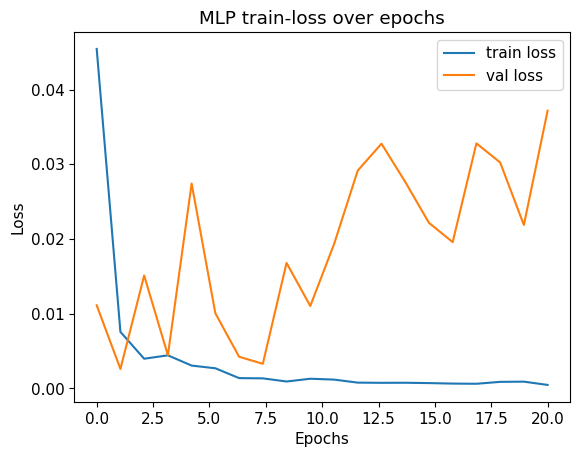

In [8]:
# Set training
best_metric = float('inf')  # Initialize with a large value for loss
train_loss_plotting = []
validation_loss_plotting = []

# Training Loop
for epoch in tqdm(range(NUM_EPOCHS)):
    train_loss = train_utils.train_step(model_MLP, train_dataloader, loss_fn, optimizer, DEVICE)
    validation_loss = train_utils.validation_step(model_MLP, valid_dataloader, loss_fn, DEVICE)

    # add train loss fro plotting
    train_loss_plotting.append(train_loss.item())
    validation_loss_plotting.append(validation_loss.item())
    
    ####################################################
    # TODO 1:
    # please fill in the code to save 
    # the currently "best" trained model. 
    # How to decide what the best model is?

    torch.save(model_MLP.state_dict(), PATH_MODEL_SAVE)

    ####################################################

#    if(epoch % 10 == 0):
#        print(f"Epoch: {epoch}\n------")
#        print(f"Train loss: {train_loss:.5f}\n")
        
# plotting stuff
%matplotlib inline
x_err = np.linspace(0, NUM_EPOCHS, NUM_EPOCHS)
plt.plot(x_err, train_loss_plotting, label='train loss')
plt.plot(x_err, validation_loss_plotting, label='val loss')

# Adding labels and title
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MLP train-loss over epochs')

# Display the plot
plt.legend()

plt.show()

### Question: 
* Can you overfit intentionally to the training data? How does the validation curve will look like? Please verify your assumption.

* Now train a well performing model. Feel free to change parameters like learning rate, number of epochs, number of layers. How do these parameters effect the result?

*Answer:*

## Part 1.2: Inference on a single image

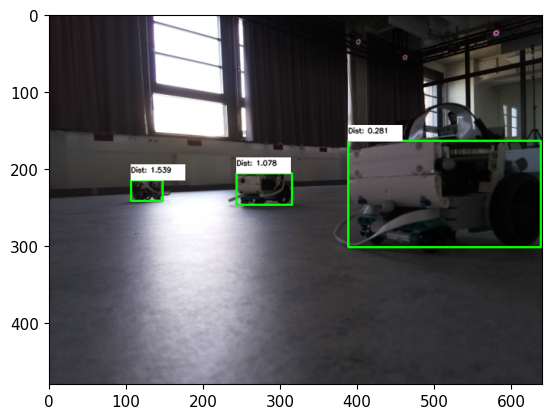

In [9]:
# loading trained model
model = mlp.MLP()
model.load_state_dict(torch.load(PATH_MODEL_SAVE, map_location=torch.device(DEVICE)))
model.eval() 

# yolo bounding box detection
res = model_YOLO(FILE)

bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]
image = cv2.imread(FILE)

for box in bounding_boxes:
    
    BBH = (box[3] - box[1]) / 640
    BBW = (box[2] - box[0]) / (640)
    BBCenter = torch.tensor([(box[2] + box[0]) / 2 , (box[3] + box[1]) / 2 ], dtype = torch.float32, device = DEVICE) / 640
    BBAspectRatio = BBW / BBH / 6
    BBClass = box[5]
    BBConf = box[4]
    BBArea = BBH * BBW
    BBAreaCover = (BBArea)
    params = torch.stack((torch.tensor(1).to(DEVICE), torch.tensor(1).to(DEVICE), BBH, BBW, BBAspectRatio, BBClass, BBConf, BBArea, BBAreaCover))
    input = torch.cat((params, BBCenter), 0)
    distance = model(input)
    
    cv2.rectangle(image, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (0, 255, 0), 2)
    image_with_rectangle = cv2.rectangle(image, (int(box[0]), int(box[1])-20), (int(box[0]) + 70, int(box[1])), (255,255,255), -1)
    img_drawn = cv2.putText(image, f"Dist: {(distance.item() * MAX_DIST):.3f}", (int(box[0]), int(box[1] - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,0), 1, cv2.LINE_AA)
    image_rgb = cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB)


# visualize frame with overlayed 
# bounding boxes and distance estimates
%matplotlib inline

fig = plt.figure()
plt.imshow(image_rgb)
plt.show()

## Part 1.3: Visualization

... now let's run this code on several consequtive frames and visualize the relationship between object height and its distance.

In [10]:
print("Loading Pictures...")

file_pattern = os.path.join(PATH_TEST, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

print("Reading pictures...")

values = {}

first_image = cv2.imread(picture_files[0])
height, width, _ = first_image.shape

for i, file in enumerate(picture_files):

    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    for box in bounding_boxes:
        BBH = (box[3] - box[1]) / 640
        BBW = (box[2] - box[0]) / 640

        BBCenter = torch.tensor([(box[2] + box[0]) / 2, (box[3] + box[1]) / 2 ], dtype = torch.float32, device = DEVICE) / 640
        BBAspectRatio = BBW / BBH / 6
        BBClass = box[5]
        BBConf = box[4]
        BBArea = BBH * BBW
        BBAreaCover = (BBArea)
        params = torch.stack((torch.tensor(1).to(DEVICE), torch.tensor(1).to(DEVICE), BBH, BBW, BBAspectRatio, BBClass, BBConf, BBArea, BBAreaCover))
        input = torch.cat((params, BBCenter), 0)
        distance = model(input)
        
        values.setdefault(distance, []).append(box[3] - box[1])



Loading Pictures...
Reading pictures...


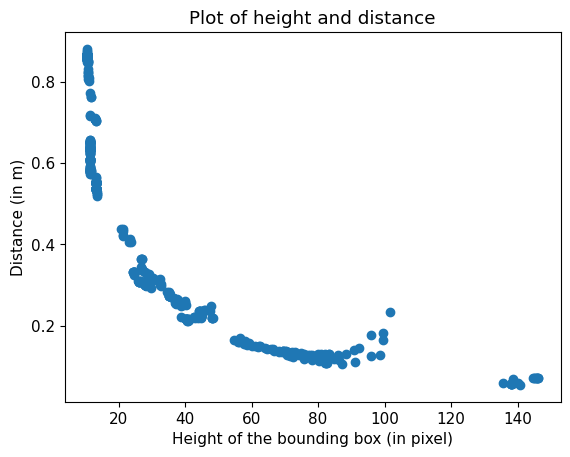

In [11]:
x = []
y = []

for dist in values:
    for height in values[dist]:
        x.append(height.item())
        y.append(dist.detach().numpy())

plt.scatter(x, y)

plt.xlabel('Height of the bounding box (in pixel)')
plt.ylabel('Distance (in m)')
plt.title('Plot of height and distance')

plt.show()

## Part 2.1: Evaluation

Groudtruth robot poses were captured with a motion capture system for all robots visible in this data. Poses were saved in the provided .csv file. In this part of the tutorial let's anayse the observed error. How does this relate to the object's distance? What are possible causes of this error?

In [13]:
# loading trained model
model = mlp.MLP()
model.load_state_dict(torch.load(PATH_MODEL_SAVE, map_location=torch.device(DEVICE)))
model.eval()

# get list of picture files in PATH
file_pattern = os.path.join(PATH_TEST, FILE_EXTENSION)
picture_files = glob.glob(file_pattern)
picture_files.sort()

# read csv file with ground truth robot poses
df = pd.read_csv(PATH_CSV_TEST, header=None)

# get column for each robot in csv file
row = df.iloc[0].to_numpy()
robot_col = {}
for rbo in ROBOTS:
    bool_array = row == rbo
    robot_col[rbo] = bool_array.argmax()
cam_robot_col = robot_col[CAM_ROBOT]

err = []
distance_x = []

for i, file in enumerate(picture_files):

    # -----------------------------------------------------------------
    # LOAD GROUNDTRUTH DISTANCES FOR EACH PICTURE
    # -----------------------------------------------------------------
    
    row_val = os.path.basename(file)
    row_matching_value = df[df.iloc[:, 0] == row_val]
    print("********")
    print(row_val)

    if row_matching_value.empty:
        print("Skipping, since no matching image name in csv")
        continue

    row = row_matching_value.index[0]

    if type(df.at[row,2]) is not str and math.isnan(df.at[row,2]):
        print("Skipping, since no robots visable on image ")
        continue
       
    # robots present in current frame
    robot_list = df.at[row,2].split()
    
    distance_gt = []
    
    for robot in zip(robot_list):
        
        # pose of the camera robot
        camX = df.at[row,cam_robot_col+2]
        camY = df.at[row,cam_robot_col]

        # pose of neighboring robot
        robotX = df.at[row, robot_col[robot[0]] + 2]
        robotY = df.at[row, robot_col[robot[0]]]

        # GROUNDTRUTH DISTANCE
        distance = np.sqrt((float(robotX)-float(camX)) ** 2 + (float(robotY)-float(camY)) ** 2)
        distance = distance / 100
        
        print(f"distance_gt: {distance}")
        
        distance = torch.tensor(distance, dtype = torch.float32,)
        distance_gt.append(distance)
        
    # -----------------------------------------------------------------
    # COMPUTE DISTANCE FROM BOUNDING BOX HEIGHT
    # -----------------------------------------------------------------
    
    res = model_YOLO(file)
    bounding_boxes = res.xyxy[0][res.xyxy[0][:, 0].sort()[1]]

    distance_estim = []
    
    for box in bounding_boxes:
    
        BBH = (box[3] - box[1]) / 640
        BBW = (box[2] - box[0]) / (640)
        BBCenter = torch.tensor([(box[2] + box[0]) / 2 , (box[3] + box[1]) / 2 ], dtype = torch.float32, device = DEVICE) / 640
        BBAspectRatio = BBW / BBH / 6
        BBClass = box[5]
        BBConf = box[4]
        BBArea = BBH * BBW
        BBAreaCover = (BBArea)
        params = torch.stack((torch.tensor(1).to(DEVICE), torch.tensor(1).to(DEVICE), BBH, BBW, BBAspectRatio, BBClass, BBConf, BBArea, BBAreaCover))
        input = torch.cat((params, BBCenter), 0)
        distance = model(input)
        distance = distance[0].detach()
        distance_estim.append(distance * MAX_DIST)
        
        print(f"distance_estim: {distance * MAX_DIST}")
        
    # -----------------------------------------------------------------
    # COMPUTE ERROR
    # -----------------------------------------------------------------
    
    if(bounding_boxes.shape[0] == len(robot_list)):

        error = abs(np.array(distance_gt) - np.array(distance_estim))
        err.extend(error)
        distance_x.extend(distance_gt)

********
2023-6-28_17-05-35-712397.png
Skipping, since no matching image name in csv
********
2023-6-28_17-05-35-764330.png
Skipping, since no matching image name in csv
********
2023-6-28_17-05-38-982314.png
distance_gt: 4.642136309325211
distance_gt: 3.8728825015836748
distance_gt: 4.401366339645449
distance_estim: 3.262876033782959
distance_estim: 2.7700905799865723
distance_estim: 4.344197750091553
********
2023-6-28_17-05-39-036497.png
distance_gt: 4.642094755589334
distance_gt: 3.8728830556334986
distance_gt: 4.401352834300173
distance_estim: 3.2924344539642334
distance_estim: 2.7626519203186035
distance_estim: 4.334854602813721
********
2023-6-28_17-05-39-141069.png
distance_gt: 4.642153031126969
distance_gt: 3.872906614254449
distance_gt: 4.401380599025648
distance_estim: 3.2810564041137695
distance_estim: 2.780811309814453
distance_estim: 4.330001354217529
********
2023-6-28_17-05-39-189926.png
distance_gt: 4.642119967202706
distance_gt: 3.872904498627394
distance_gt: 4.401376

distance_estim: 3.184019088745117
distance_estim: 2.760671377182007
distance_estim: 4.258642196655273
distance_estim: 0.6438287496566772
********
2023-6-28_17-05-41-391222.png
distance_gt: 4.642129284665381
distance_gt: 3.872882244031932
distance_gt: 4.401371260325463
distance_gt: 0.6842283617411524
distance_estim: 3.188282012939453
distance_estim: 2.7699356079101562
distance_estim: 4.252216339111328
distance_estim: 0.6414049863815308
********
2023-6-28_17-05-41-500613.png
distance_gt: 4.64210111190465
distance_gt: 3.8728864311167324
distance_gt: 4.401374279352071
distance_gt: 0.7118943614392801
distance_estim: 3.1749978065490723
distance_estim: 2.756619691848755
distance_estim: 4.262691020965576
distance_estim: 0.6399725675582886
********
2023-6-28_17-05-41-554416.png
distance_gt: 4.642139199842214
distance_gt: 3.8729243907943967
distance_gt: 4.401401310882094
distance_gt: 0.725176371431392
distance_estim: 3.165651321411133
distance_estim: 2.7522385120391846
distance_estim: 4.23164272

distance_estim: 1.5041757822036743
distance_estim: 2.9113011360168457
distance_estim: 2.6793570518493652
distance_estim: 4.2824201583862305
********
2023-6-28_17-05-49-349114.png
distance_gt: 1.8661245923947625
distance_gt: 4.642126246291528
distance_gt: 3.872905713521673
distance_gt: 4.401379480153817
distance_estim: 1.5151705741882324
distance_estim: 2.894497871398926
distance_estim: 2.681847095489502
distance_estim: 4.275639057159424
********
2023-6-28_17-05-49-453017.png
distance_gt: 1.8892226099173621
distance_gt: 4.642078875882157
distance_gt: 3.872858694235167
distance_gt: 4.401330788820972
distance_estim: 1.5104262828826904
distance_estim: 2.8696885108947754
distance_estim: 2.6891934871673584
distance_estim: 4.2937188148498535
********
2023-6-28_17-05-49-504028.png
distance_gt: 1.9009471511559508
distance_gt: 4.642137734980815
distance_gt: 3.8729084729407486
distance_gt: 4.401397695857867
distance_estim: 1.5144391059875488
distance_estim: 2.896939277648926
distance_estim: 2.686

distance_estim: 0.621906578540802
********
2023-6-28_17-06-25-281451.png
distance_gt: 0.7446771012745497
distance_estim: 0.59998619556427
********
2023-6-28_17-06-25-329837.png
distance_gt: 0.7321362479272422
distance_estim: 0.5736047029495239
********
2023-6-28_17-06-25-381067.png
distance_gt: 0.7181601345542395
distance_estim: 0.5466971397399902
********
2023-6-28_17-06-29-524263.png
distance_gt: 1.3642972226495136
distance_gt: 0.5941307746213084
distance_estim: 1.3692781925201416
distance_estim: 0.5427834391593933
********
2023-6-28_17-06-29-622542.png
Skipping, since no matching image name in csv
********
2023-6-28_17-06-29-678911.png
Skipping, since no matching image name in csv
********
2023-6-28_17-06-29-735763.png
Skipping, since no matching image name in csv
********
2023-6-28_17-06-29-790833.png
Skipping, since no matching image name in csv
********
2023-6-28_17-06-29-872870.png
distance_gt: 1.3957941732156425
distance_gt: 0.6194296054459555
distance_estim: 1.4138336181640625

## Part 2.2: Visualization
...now let's visualize again.

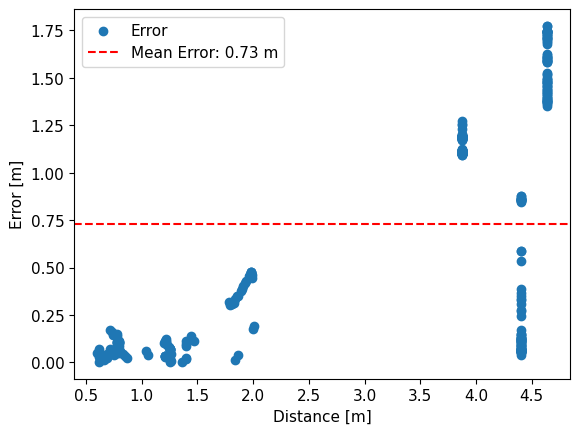

In [14]:
plt.scatter(distance_x, err, label='Error')
mean_err = np.mean(err)
plt.axhline(y=mean_err, color='r', linestyle='--', label=f'Mean Error: {mean_err:.2f} m')

# Adding labels and title
plt.xlabel('Distance [m]')
plt.ylabel('Error [m]')

# Display the plot
plt.legend()
plt.show(block=True)

## Question 1:
Please describe the behavior of the error. What are possible causes for errors that you observe? (Please name at least three causes)

*Answer:*